# Identification of active compounds

Cells were treated with various compounds, some have known mode of action (MoA), and some have unknown ones. Negative controls were produced by treating cells with Dimethylsulfoxide (DMSO), which has no MoA. One way to identify highly active compounds would be to compare their effect to the effect of DMSO, which is the nagative control. In order to do this, we aim at comparing the embeddings of images of cells treated with each compound, to the embeddings of images of cells treated with DMSO, using distance based metrics. Embedding vecotrs that are close to those obtained with DMSO are the ones with the lowes activity, while those that are far away are the most highly active. 

In [102]:
#we first import the required packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
import random
import altair as alt


import warnings
warnings.filterwarnings('ignore')



In [12]:
#we load the embeddings
file_name = 'bbbc021_image_embed_compact_batchcorr.csv'
df = pd.read_csv(file_name)
df.head()


,Metadata_PlateNumber,Metadata_ID,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Replicate,Metadata_Compound,Metadata_Concentration,Metadata_SMILES,Metadata_MoA,Z000_DAPI,...,Z1014_Actin,Z1015_Actin,Z1016_Actin,Z1017_Actin,Z1018_Actin,Z1019_Actin,Z1020_Actin,Z1021_Actin,Z1022_Actin,Z1023_Actin
0,27481,4_233,4,233,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,0.000048,...,0.454990,0.134093,-0.183729,-0.274622,-0.334495,1.243070,-0.255104,0.963327,-0.121460,-0.326638
1,27481,4_234,4,234,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,0.000206,...,0.092730,0.190641,-0.165633,0.213599,0.029494,1.540971,-0.525035,1.661467,0.396143,-0.416450
2,27481,4_235,4,235,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,0.000031,...,0.616472,0.227196,-0.220849,-0.269494,-0.428935,1.160149,-0.225761,0.551435,-0.046371,-0.471649
3,27481,4_236,4,236,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,0.000046,...,0.285652,0.394520,-0.290574,-0.200597,-0.159741,0.774231,-0.249552,1.224972,-0.016013,-0.381165
4,27521,4_473,4,473,2,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,NaN,0.000330,...,-0.020315,0.140883,-0.109927,0.289298,-0.066874,1.750260,-0.640512,1.972492,0.889125,-0.850808


In [10]:
df.Metadata_Compound.unique()

array(['5-fluorouracil', 'acyclovir', 'AG-1478', 'ALLN', 'aloisine A',
       'alsterpaullone', 'anisomycin', 'aphidicolin',
       'arabinofuranosylcytosine', 'atropine', 'bleomycin', 'bohemine',
       'brefeldin A', 'bryostatin', 'calpain inhibitor 2 (ALLM)',
       'calpeptin', 'camptothecin', 'carboplatin',
       'caspase inhibitor 1 (ZVAD)', 'cathepsin inhibitor I',
       'Cdk1 inhibitor III', 'Cdk1/2 inhibitor (NU6102)', 'chlorambucil',
       'chloramphenicol', 'cisplatin', 'colchicine', 'cyclohexamide',
       'cyclophosphamide', 'cytochalasin B', 'cytochalasin D',
       'demecolcine', 'deoxymannojirimycin', 'deoxynojirimycin',
       "3,3'-diaminobenzidine", 'docetaxel', 'doxorubicin', 'emetine',
       'epothilone B', 'etoposide', 'filipin', 'floxuridine', 'forskolin',
       'genistein', 'H-7', 'herbimycin A', 'hydroxyurea', 'ICI-182,780',
       'indirubin monoxime', 'jasplakinolide', 'lactacystin',
       'latrunculin B', 'leupeptin', 'LY-294002', 'methotrexate',
     

## 1) Dimensionality reduction
The image embeddings consist in more than 3000 features. We want to apply dimensionality reduction to both reduce the number of features, and to apply whitening which will help removing the noise from the picture embeddings. We will apply PCA with whitening, and keep the 64 to 256 first principal components to proceed with the vector similarity measurements. To ensure we remove the noise from the pictures, we will fit the PCA on the pictures obtained with DMSO only, and then transform the whole dataset.

In [53]:
#first we select the features that are important (i.e. the embeddings themselves) in the dataframe
data = df.iloc[:, 9:]

#then we normalize the data
sc = StandardScaler()
data = sc.fit_transform(data)

#we transform back the np.array into a pd.DataFrame, and add the compound column to be able to select those which correspond to DMSO
df_pca = pd.DataFrame(data)
df_pca['compound'] = df.Metadata_Compound
df_pca

#now we select only the ones corresponding to DMSO
df_dmso = df_pca[df_pca.compound == 'DMSO']

#and we use it to fit the PCA, either with the first 64, 128, or 256 first principal components
pca_list = []
for n in [32, 64, 128, 256]:
    pca = PCA(n_components=n, whiten = True)
    pca.fit(df_dmso.iloc[:, :-1])
    pca_list.append(pca)

#and we transform the three datasets into a pd.DataFrame again, and append the compounds column
df_pca_list = []
for pca in pca_list:
    df_ = pd.DataFrame(pca.transform(data))
    df_['compound'] = df.Metadata_Compound
    df_pca_list.append(df_)


Let's now have a look at the cumulated explained variance ratio of each pca object we've created. We will plot the cumulated explained variance ratio of the four pca (with 32, 64, 182 and 256 first components respectively) as bar chart.

''

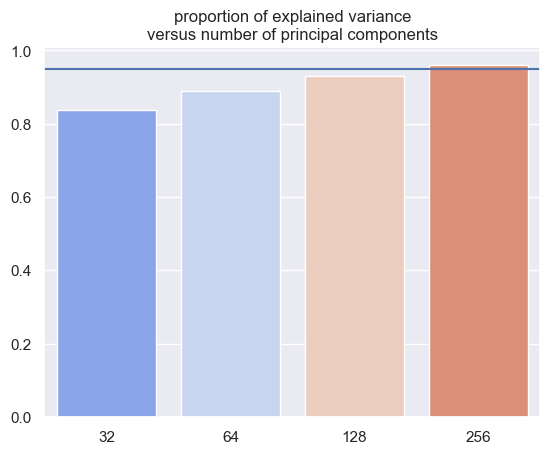

In [87]:
sns.set()
sns.barplot([32, 64, 128, 256], [pca_list[n].explained_variance_ratio_.sum() for n in range(4)], palette="coolwarm")
plt.axhline(y = 0.95) #we add a horizontal line at .95% so better visualize which pca reach 95% of explained variance
plt.title('proportion of explained variance\nversus number of principal components')
;


We can see that only the pca with the first 256 principal components explain more than 95% of the variance of the original dataset. We will therefore proceed with the 256 first principal components. 

## 2) Compound activity estimation by comparison to DMSO
We will now calculate the difference in the principal components vectors of the different compounds, with the principal components vectors of DMSO. For this, we will group the dataset by compound, and average the vectors for each compound. Then, we will measure the euclidian distance and cosine similarity betwen the average pca vector of each compound and the average pca vector of DMSO.

In [76]:
#we first extract the dataframe which contains the 256 first principal components
df_reduced = df_pca_list[3]

#we first calculate the mean vector for each compound
df_mean = df_reduced.groupby('compound').mean().reset_index() 

#then we group the mean vector into a single column of the DataFrame 
df_mean['mean_vector'] = df_mean.apply(lambda x: np.array([x[n] for n in list(range(0, df_mean.shape[1] - 1))]), axis = 1) 

#we now remove the individual values to simplify the dataframe
df_mean = df_mean[['compound','mean_vector']]

#we now locate the vector corresponding to DMSO
mean_vector_DMSO = df_mean[df_mean.compound == 'DMSO'].iloc[0].mean_vector

#and we calculate the euclidian distance between this vector and each compound vector
df_mean['euclidian_distance'] = df_mean.mean_vector.apply(lambda x: euclidean(x, mean_vector_DMSO))
    
df_mean.head()

,compound,mean_vector,euclidian_distance
0,"3,3'-diaminobenzidine","[0.8589102699991583, -0.4876964936006538, -0.1...",4.246954
1,5-fluorouracil,"[-0.09909743250318657, -0.40368144967188496, -...",4.093646
2,AG-1478,"[0.3280934898659403, -0.17783801044816627, -0....",3.564196
3,ALLN,"[0.8707937883627127, -0.4701948340168647, 0.22...",6.801931
4,AZ-A,"[0.5240839761381616, -0.5917490510193474, -0.6...",18.282564


In [134]:
#let's now plot the euclidian distance of each compound with DMSO

# sns.barplot(df_mean.sort_values('euclidian_distance').compound, df_mean.sort_values('euclidian_distance').euclidian_distance)

bar = alt.Chart(df_mean).mark_bar(size = 10).encode(
    x = alt.X('euclidian_distance:Q',
             axis = alt.Axis(
             title = 'Euclidian distance with DMSO'), scale=alt.Scale(padding=0)),
    y = alt.Y('compound:N',
             axis = alt.Axis(title = ''), sort='-x', scale=alt.Scale(padding=0)))

bar

alt.Chart(...)